# Week 9-1: Unsupervised Machine Learning

## Bibliotheken importeren

In [263]:
import pandas as pd
from sklearn.cluster import KMeans
import math
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.simplefilter('ignore')
import sqlite3
go_sales_connect = sqlite3.connect('go_sales.sqlite')
go_crm_connect = sqlite3.connect('go_crm.sqlite')

## Data inlezen en kolommen selecteren

In [264]:
df = pd.read_sql_query("SELECT sales_branch.SALES_BRANCH_CODE, CITY, REGION, sales_branch.COUNTRY_CODE, COUNT(ORDER_NUMBER) from sales_branch join country on country.COUNTRY_CODE = sales_branch.COUNTRY_CODE join order_header on order_header.SALES_BRANCH_CODE = sales_branch.SALES_BRANCH_CODE GROUP BY sales_branch.SALES_BRANCH_CODE", go_sales_connect)
df2 = pd.read_sql_query("SELECT country_code, sales_territory_code from country", go_crm_connect)
df = pd.merge(df, df2, on='COUNTRY_CODE', how='left')
df

,SALES_BRANCH_CODE,CITY,REGION,COUNTRY_CODE,COUNT(ORDER_NUMBER),SALES_TERRITORY_CODE
0,13,Hamburg,None,2,271,6
1,14,München,None,2,231,6
2,15,Kista,None,10,282,5
3,17,Calgary,Alberta,4,123,1
4,18,Toronto,Ontario,4,330,1
5,19,Boston,Massachusetts,3,515,1
6,20,Seattle,Washington,3,334,1
7,21,Los Angeles,California,3,384,1
8,22,Miami,Florida,3,193,1
9,23,Lyon,None,1,174,6


In [265]:
# df['ADDRESS1'] = df['ADDRESS1'].astype(str)
# df.dtypes

## One-hot encoding van onafhankelijke niet-numerieke variabelen

In [266]:
# df['Pclass'] = df['Pclass'].astype(str)
# df.dtypes

In [267]:
dummies_df1 = pd.get_dummies(df.loc[:, ["SALES_BRANCH_CODE",	"CITY",	"REGION",	"COUNTRY_CODE",	"COUNT(ORDER_NUMBER)",	"SALES_TERRITORY_CODE"]])
dummies_df1

,COUNT(ORDER_NUMBER),SALES_BRANCH_CODE_13,SALES_BRANCH_CODE_14,SALES_BRANCH_CODE_15,SALES_BRANCH_CODE_17,SALES_BRANCH_CODE_18,SALES_BRANCH_CODE_19,SALES_BRANCH_CODE_20,SALES_BRANCH_CODE_21,SALES_BRANCH_CODE_22,...,COUNTRY_CODE_5,COUNTRY_CODE_6,COUNTRY_CODE_7,COUNTRY_CODE_8,COUNTRY_CODE_9,SALES_TERRITORY_CODE_1,SALES_TERRITORY_CODE_4,SALES_TERRITORY_CODE_5,SALES_TERRITORY_CODE_6,SALES_TERRITORY_CODE_7
0,271,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,231,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,282,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,123,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,330,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
5,515,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
6,334,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
7,384,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
8,193,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
9,174,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [268]:
# df = pd.concat([df, dummies_dataframe], axis = 1)
# df = df.drop(['Sex'], axis = 1)
# df = df.loc[:, ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Age', 'Survived']]
# df

## Clusteringmodel bouwen met 2 dimensies

In [269]:
# df_2d = df.loc[:, ['Age', 'Survived']]
# df_2d

In [270]:
kmeans = KMeans(n_clusters = 5, random_state = 42)
kmeans.fit_predict(dummies_df1)

array([2, 3, 2, 1, 2, 0, 2, 2, 3, 3, 1, 1, 3, 1, 1, 4, 4, 1, 1, 1, 3, 3,
       1, 1, 3, 3, 3, 2], dtype=int32)

In [271]:
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)
kmeans_centra

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,515.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
1,120.900000,6.938894e-18,6.938894e-18,6.938894e-18,1.000000e-01,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,...,6.938894e-18,6.938894e-18,6.938894e-18,1.000000e-01,1.387779e-17,0.200000,5.000000e-01,1.387779e-17,0.200000,1.000000e-01
2,313.333333,1.666667e-01,6.938894e-18,1.666667e-01,6.938894e-18,1.666667e-01,6.938894e-18,1.666667e-01,1.666667e-01,6.938894e-18,...,6.938894e-18,6.938894e-18,1.666667e-01,6.938894e-18,1.387779e-17,0.500000,2.775558e-17,3.333333e-01,0.166667,1.387779e-17
3,185.222222,6.938894e-18,1.111111e-01,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,1.111111e-01,...,1.111111e-01,1.111111e-01,6.938894e-18,6.938894e-18,2.222222e-01,0.111111,1.111111e-01,2.775558e-17,0.555556,2.222222e-01
4,44.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.500000,0.000000e+00,5.000000e-01,0.000000,0.000000e+00


In [272]:
for i in range(len(kmeans_centra.columns)):
    kmeans_centra = kmeans_centra.rename(columns = {i : f'{dummies_df1.columns[i]}'})
    
kmeans_centra

,COUNT(ORDER_NUMBER),SALES_BRANCH_CODE_13,SALES_BRANCH_CODE_14,SALES_BRANCH_CODE_15,SALES_BRANCH_CODE_17,SALES_BRANCH_CODE_18,SALES_BRANCH_CODE_19,SALES_BRANCH_CODE_20,SALES_BRANCH_CODE_21,SALES_BRANCH_CODE_22,...,COUNTRY_CODE_5,COUNTRY_CODE_6,COUNTRY_CODE_7,COUNTRY_CODE_8,COUNTRY_CODE_9,SALES_TERRITORY_CODE_1,SALES_TERRITORY_CODE_4,SALES_TERRITORY_CODE_5,SALES_TERRITORY_CODE_6,SALES_TERRITORY_CODE_7
0,515.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
1,120.900000,6.938894e-18,6.938894e-18,6.938894e-18,1.000000e-01,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,...,6.938894e-18,6.938894e-18,6.938894e-18,1.000000e-01,1.387779e-17,0.200000,5.000000e-01,1.387779e-17,0.200000,1.000000e-01
2,313.333333,1.666667e-01,6.938894e-18,1.666667e-01,6.938894e-18,1.666667e-01,6.938894e-18,1.666667e-01,1.666667e-01,6.938894e-18,...,6.938894e-18,6.938894e-18,1.666667e-01,6.938894e-18,1.387779e-17,0.500000,2.775558e-17,3.333333e-01,0.166667,1.387779e-17
3,185.222222,6.938894e-18,1.111111e-01,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,1.111111e-01,...,1.111111e-01,1.111111e-01,6.938894e-18,6.938894e-18,2.222222e-01,0.111111,1.111111e-01,2.775558e-17,0.555556,2.222222e-01
4,44.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.500000,0.000000e+00,5.000000e-01,0.000000,0.000000e+00


In [273]:
for src_index, _ in dummies_df1.iterrows():
    euclidian_distances = dict()
    print(f"Afstand van bronindex {src_index} tot...")

    for centrumindex, _ in kmeans_centra.iterrows():
        print(f"\tCentrumindex {centrumindex}:")
        euclidian_sum = 0

        for column_name in kmeans_centra.columns:
            current_difference = dummies_df1.at[src_index, column_name] - kmeans_centra.at[centrumindex, column_name]
            print(f'\t\t{dummies_df1.at[src_index, column_name]} - {kmeans_centra.at[centrumindex, column_name]} = {current_difference}')
            euclidian_sum += current_difference ** 2
        
        print(f'\tTotale euclidische som: {euclidian_sum}')
        euclidian_distance = math.sqrt(euclidian_sum)
        print(f'\tEuclidische afstand: {euclidian_distance}')
        euclidian_distances[centrumindex] = euclidian_distance
        print('------------------------------------------------')
    
    print(euclidian_distances)
    centrum_number = min(euclidian_distances, key = euclidian_distances.get)
    print(centrum_number)
    dummies_df1.at[src_index, 'Centrum'] = centrum_number
    print("================================================")

dummies_df1

Afstand van bronindex 0 tot...
	Centrumindex 0:
		271 - 515.0 = -244.0
		True - 0.0 = 1.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 1.0 = -1.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 1.0 = -1.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		True - 0.0 = 1.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False -

,COUNT(ORDER_NUMBER),SALES_BRANCH_CODE_13,SALES_BRANCH_CODE_14,SALES_BRANCH_CODE_15,SALES_BRANCH_CODE_17,SALES_BRANCH_CODE_18,SALES_BRANCH_CODE_19,SALES_BRANCH_CODE_20,SALES_BRANCH_CODE_21,SALES_BRANCH_CODE_22,...,COUNTRY_CODE_6,COUNTRY_CODE_7,COUNTRY_CODE_8,COUNTRY_CODE_9,SALES_TERRITORY_CODE_1,SALES_TERRITORY_CODE_4,SALES_TERRITORY_CODE_5,SALES_TERRITORY_CODE_6,SALES_TERRITORY_CODE_7,Centrum
0,271,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,2.0
1,231,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,3.0
2,282,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,2.0
3,123,False,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,1.0
4,330,False,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,2.0
5,515,False,False,False,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,0.0
6,334,False,False,False,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,2.0
7,384,False,False,False,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,2.0
8,193,False,False,False,False,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,3.0
9,174,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,3.0


In [274]:
# Interclusterafstand
for i in kmeans_centra.index:
    for j in kmeans_centra.index:
        if i != j:
            diff = kmeans_centra.loc[i] - kmeans_centra.loc[j]
            dist = np.sqrt(np.sum(diff**2))
            print(f"Interclusterafstand tussen cluster {i} en cluster {j}: {dist}")

# Intraclusterafstand
for i in kmeans_centra.index:
    cluster_points = dummies_df1[dummies_df1['Centrum'] == i]
    distances = []
    for _, point in cluster_points.iterrows():
        diff = point[:-1] - kmeans_centra.loc[i]
        dist = np.sqrt(np.sum(diff**2))
        distances.append(dist)
    avg_distance = np.mean(distances)
    print(f"Gemiddelde intraclusterafstand voor cluster {i}: {avg_distance}")



Interclusterafstand tussen cluster 0 en cluster 1: 394.10672412431643
Interclusterafstand tussen cluster 0 en cluster 2: 201.6775479158088
Interclusterafstand tussen cluster 0 en cluster 3: 329.78590136744896
Interclusterafstand tussen cluster 0 en cluster 4: 470.50664182347094
Interclusterafstand tussen cluster 1 en cluster 0: 394.10672412431643
Interclusterafstand tussen cluster 1 en cluster 2: 192.43711526972479
Interclusterafstand tussen cluster 1 en cluster 3: 64.33044610677204
Interclusterafstand tussen cluster 1 en cluster 4: 76.41799526289601
Interclusterafstand tussen cluster 2 en cluster 0: 201.6775479158088
Interclusterafstand tussen cluster 2 en cluster 1: 192.43711526972479
Interclusterafstand tussen cluster 2 en cluster 3: 128.11677254523468
Interclusterafstand tussen cluster 2 en cluster 4: 268.83793135146186
Interclusterafstand tussen cluster 3 en cluster 0: 329.78590136744896
Interclusterafstand tussen cluster 3 en cluster 1: 64.33044610677204
Interclusterafstand tusse

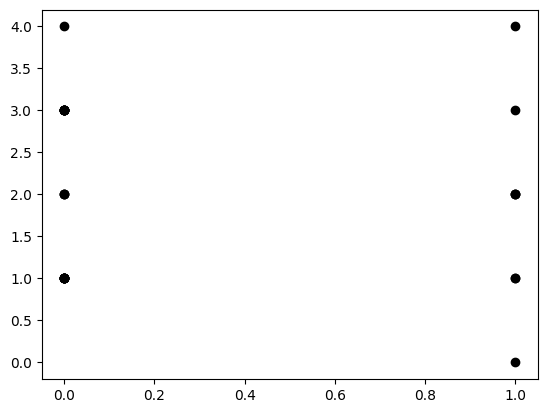

In [275]:
plt.scatter(dummies_df1['SALES_TERRITORY_CODE_1'], dummies_df1['Centrum'], color = 'k')
plt.show()

In [276]:
dummies_df1.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,1
1,10
2,6
3,9
4,2


## Clusteringmodel bouwen met meer dan 2 dimensies (alle kolommen uit de dataset)

### Centra berekenen

In [277]:
kmeans = KMeans(n_clusters = 6, random_state = 42)
prediction_results = kmeans.fit_predict(dummies_df1)
prediction_results

array([0, 0, 0, 1, 2, 3, 2, 2, 4, 4, 4, 1, 4, 1, 1, 5, 1, 1, 1, 1, 4, 4,
       1, 1, 4, 4, 4, 0], dtype=int32)

In [278]:
df['Centrum'] = prediction_results
df

,SALES_BRANCH_CODE,CITY,REGION,COUNTRY_CODE,COUNT(ORDER_NUMBER),SALES_TERRITORY_CODE,Centrum
0,13,Hamburg,None,2,271,6,0
1,14,München,None,2,231,6,0
2,15,Kista,None,10,282,5,0
3,17,Calgary,Alberta,4,123,1,1
4,18,Toronto,Ontario,4,330,1,2
5,19,Boston,Massachusetts,3,515,1,3
6,20,Seattle,Washington,3,334,1,2
7,21,Los Angeles,California,3,384,1,2
8,22,Miami,Florida,3,193,1,4
9,23,Lyon,None,1,174,6,4


### De juiste centra toewijzen aan rijen uit de dataset

In [279]:
df.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,4
1,10
2,3
3,1
4,9
5,1


## Evalueren

we hebben verschillende aantal klusters geprobeert. Bij hogere aantal klusters krijg je steeds eilanden met maar een punt. hierom is 5 het beste want het is het laagste aantal klusters waarbij én de inter én de intra verbeterd. Bij het toenemen krijg je meer eilanden en worden de inter en intra alleen maar SUBJECTIEF beter.